## Домашнее задание 2

Студент: Киселев Георгий

In [1]:
import os
import gdown
import zipfile
import torch
import torchvision.datasets as datasets
import torchvision.transforms as transforms

from torch import nn
from pathlib import Path
import torch.optim as optim
from torchvision.utils import make_grid

from torch.utils.tensorboard import SummaryWriter
from IPython.display import clear_output, display
import matplotlib.pyplot as plt
import numpy as np

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

### Загрузка датасета

In [3]:
os.makedirs('dataset/celeba', exist_ok=True)

if 'img_align_celeba.zip' not in os.listdir():
    url = 'https://drive.google.com/uc?id=0B7EVK8r0v71pZjFTYXZWM3FlRnM'
    output = 'dataset/celeba/img_align_celeba.zip'
    gdown.download(url, output, quiet=False)
else:
    if len(os.listdir('dataset/celeba')) == 0:
        with zipfile.ZipFile('img_align_celeba.zip') as zip:
            zip.extractall('dataset/celeba')

### Подготовка датасета

Используем загрузчики данных, аналогичные описанным в репозитории

In [4]:
root_path = Path(os.getcwd())
dataset_path = os.path.join(root_path, 'dataset\\celeba')
shape_target = 128

In [5]:
dataset = datasets.ImageFolder(
    root=dataset_path,
    transform=transforms.Compose([
        transforms.Resize(shape_target),
        transforms.CenterCrop(shape_target),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])
)

In [6]:
batch_size = 32
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2)

### Создание модели

#### CSPup блок

В CSPUp-блоке решено использовать ConvTranspose2d как предположительно более эффективный способ преобразования (за счет того, что он обучаем). Архитектура соответствует указанной в задании. Параметр stride отвечает за увеличение размерности и уменьшение количества каналов

Источник: https://discuss.pytorch.org/t/upsample-conv2d-vs-convtranspose2d/138081

In [7]:
class CSPup(nn.Module):

    def __init__(self, n_channels_start=1024, stride=2):

        super(CSPup, self).__init__()
        self.stride = stride
        self.n_channels_start = n_channels_start
        self.n_channels_target = n_channels_start // stride
        
        self.left_upsample = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=self.n_channels_target,
                out_channels=self.n_channels_target,
                kernel_size=4,
                stride=stride,
                padding=1,
                bias=False
            ),
            nn.BatchNorm2d(self.n_channels_target),
            nn.ReLU()
        )

        self.right_upsample = nn.Sequential(
            nn.Conv2d(
                in_channels=self.n_channels_target,
                out_channels=self.n_channels_target,
                kernel_size=1,
                stride=1,
                padding=0,
                bias=False
            ),
            nn.BatchNorm2d(self.n_channels_target),
            nn.ReLU(),
            nn.ConvTranspose2d(
                in_channels=self.n_channels_target,
                out_channels=self.n_channels_target,
                kernel_size=4,
                stride=stride,
                padding=1,
                bias=False
            ),
            nn.BatchNorm2d(self.n_channels_target),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=self.n_channels_target,
                out_channels=self.n_channels_target,
                kernel_size=3,
                stride=1,
                padding=1,
                bias=False
            ),
            nn.BatchNorm2d(self.n_channels_target),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=self.n_channels_target,
                out_channels=self.n_channels_target,
                kernel_size=3,
                stride=1,
                padding=1,
                bias=False
            ),
            nn.BatchNorm2d(self.n_channels_target),
            nn.ReLU()
        )

    def forward(self, x):
        x_left, x_right = torch.chunk(x, 2, dim=1)
        x_left = self.left_upsample(x_left)
        x_right = self.right_upsample(x_right)
        
        return x_left + x_right

Определим класс генератора, для бейслайна используем предложенную архитектуру: 4 блока CSPup (каналы уменьшаются от 1024 до 64, размерность матриц признаков возрастает от 4 до 64). На последнем слое преобразуем с помощью ConvTranspose2d в трехканальное изображение 128 на 128

In [8]:
class Generator(nn.Module):
    def __init__(self, n_channels_start, n_channels_target, stride):
        super(Generator, self).__init__()
        self.first_cspup = CSPup(n_channels_start, stride)
        self.second_cspup = CSPup(n_channels_start // stride, stride)
        self.third_cspup = CSPup(n_channels_start // (stride**2), stride)
        self.fourth_cspup = CSPup(n_channels_start // (stride**3), stride)
        self.last_deconv = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=n_channels_start // (stride**4),
                out_channels=n_channels_target,
                kernel_size=4,
                stride=2,
                padding=1
            ),
            nn.ReLU()
        )

    def forward(self, x):
        x = self.first_cspup(x)
        x = self.second_cspup(x)
        x = self.third_cspup(x)
        x = self.fourth_cspup(x)

        return self.last_deconv(x)

Дискриминатор взят из репозитория (DCGan)

In [9]:
class Discriminator(nn.Module):
    def __init__(self, n_channels_in=3, base_n_features=64):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(

            nn.Conv2d(
                in_channels=n_channels_in,
                out_channels=base_n_features, 
                kernel_size=4,
                stride=2, 
                padding=1,
                bias=False
            ),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(
                in_channels=base_n_features,
                out_channels=base_n_features * 2, 
                kernel_size=4,
                stride=2, 
                padding=1,
                bias=False
            ),
            nn.BatchNorm2d(base_n_features * 2),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(
                in_channels=base_n_features * 2,
                out_channels=base_n_features * 4, 
                kernel_size=4,
                stride=2, 
                padding=1,
                bias=False
            ),
            nn.BatchNorm2d(base_n_features * 4),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(
                in_channels=base_n_features * 4,
                out_channels=base_n_features * 8, 
                kernel_size=4,
                stride=2, 
                padding=1,
                bias=False
            ),
            nn.BatchNorm2d(base_n_features * 8),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(
                in_channels=base_n_features * 8,
                out_channels=base_n_features * 16, 
                kernel_size=4,
                stride=2, 
                padding=1,
                bias=False
            ),
            nn.BatchNorm2d(base_n_features * 16),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(
                in_channels=base_n_features * 16,
                out_channels=1, 
                kernel_size=4,
                stride=1, 
                padding=0,
                bias=False
            )
        )

    def forward(self, input):
        return self.main(input) 

### Обучение

#### Параметры

Начинаем с генерации шума 4x4x1024, в качестве функции потерь и других параметров используем стандартные предложенные значения

In [14]:
n_channels_start = 1024
n_channels_target = 3
shape_start = 4
stride = 2
n_epochs = 5

generator = Generator(n_channels_start, n_channels_target, stride).to(device)
discriminator = Discriminator(n_channels_target).to(device)

In [15]:
criterion = nn.BCEWithLogitsLoss()

fixed_noise = torch.randn(batch_size, n_channels_start, shape_start, shape_start).to(device)

real_label = 1.
fake_label = 0.

lr = 0.0002
beta1 = 0.5

optimizer_gen = optim.Adam(generator.parameters(), lr=lr, betas=(beta1, 0.999))
optimizer_disc = optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, 0.999))

#### Обучение

Дополним предложенный train loop логгированием в tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 23908), started 6:22:15 ago. (Use '!kill 23908' to kill it.)

[0/5][0/6332]	Loss_D: 1.4138	Loss_G: 6.2251	D(x): -0.1922	D(G(z)): -0.2480 / -6.2229


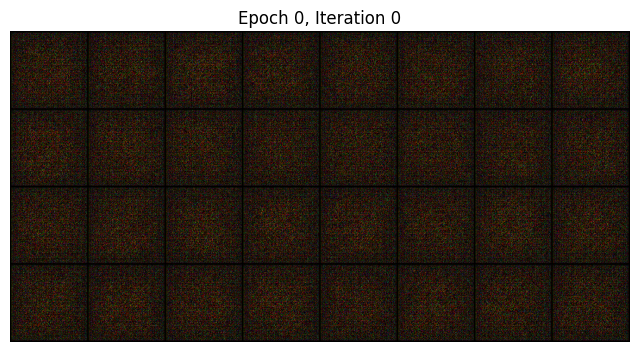

[0/5][50/6332]	Loss_D: 0.4654	Loss_G: 11.5419	D(x): 5.7580	D(G(z)): -0.6380 / -11.5419
[0/5][100/6332]	Loss_D: 0.0049	Loss_G: 6.3778	D(x): 7.9151	D(G(z)): -6.3241 / -6.3760
[0/5][150/6332]	Loss_D: 0.0276	Loss_G: 6.5756	D(x): 5.1436	D(G(z)): -6.0489 / -6.5742
[0/5][200/6332]	Loss_D: 0.0043	Loss_G: 7.0041	D(x): 10.1782	D(G(z)): -5.9197 / -7.0032


<Figure size 640x480 with 0 Axes>

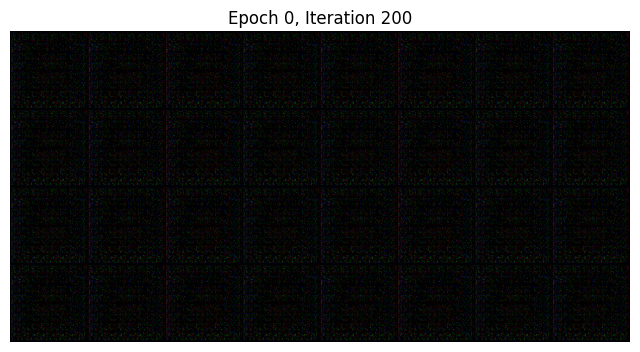

[0/5][250/6332]	Loss_D: 0.0010	Loss_G: 7.5218	D(x): 11.1272	D(G(z)): -7.0456 / -7.5213
[0/5][300/6332]	Loss_D: 0.0007	Loss_G: 7.8254	D(x): 11.1621	D(G(z)): -7.5250 / -7.8250
[0/5][350/6332]	Loss_D: 0.0017	Loss_G: 7.2984	D(x): 8.8779	D(G(z)): -7.1847 / -7.2977
[0/5][400/6332]	Loss_D: 0.0027	Loss_G: 7.8815	D(x): 11.3892	D(G(z)): -7.7594 / -7.8811


<Figure size 640x480 with 0 Axes>

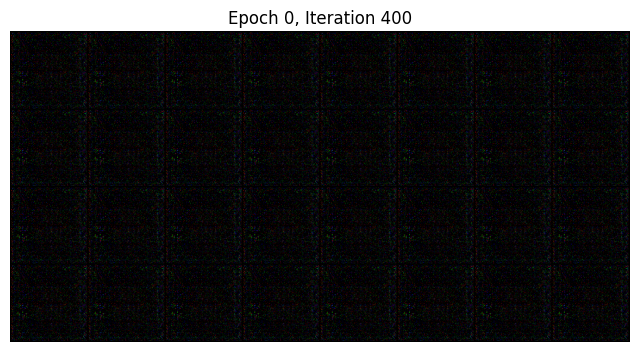

[0/5][450/6332]	Loss_D: 0.0008	Loss_G: 7.8212	D(x): 9.6410	D(G(z)): -7.6457 / -7.8208
[0/5][500/6332]	Loss_D: 0.0005	Loss_G: 7.9878	D(x): 12.4612	D(G(z)): -7.5823 / -7.9875
[0/5][550/6332]	Loss_D: 0.0003	Loss_G: 8.5738	D(x): 12.9323	D(G(z)): -8.3648 / -8.5736
[0/5][600/6332]	Loss_D: 0.0002	Loss_G: 8.6632	D(x): 12.9007	D(G(z)): -8.5141 / -8.6631


<Figure size 640x480 with 0 Axes>

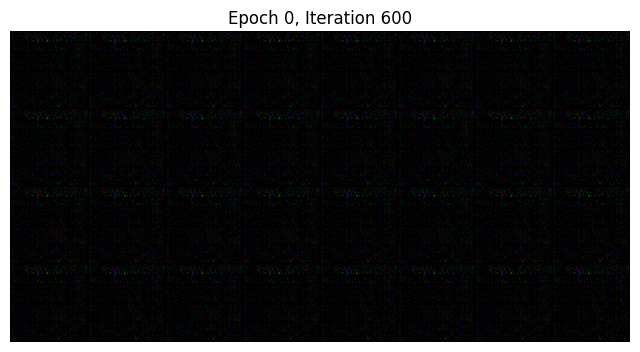

[0/5][650/6332]	Loss_D: 0.0002	Loss_G: 8.8027	D(x): 14.5482	D(G(z)): -8.6858 / -8.8026
[0/5][700/6332]	Loss_D: 0.0001	Loss_G: 9.0704	D(x): 13.5458	D(G(z)): -8.9884 / -9.0703
[0/5][750/6332]	Loss_D: 0.0001	Loss_G: 9.6065	D(x): 13.0582	D(G(z)): -9.5509 / -9.6064
[0/5][800/6332]	Loss_D: 0.0001	Loss_G: 9.6404	D(x): 12.3954	D(G(z)): -9.5834 / -9.6404


<Figure size 640x480 with 0 Axes>

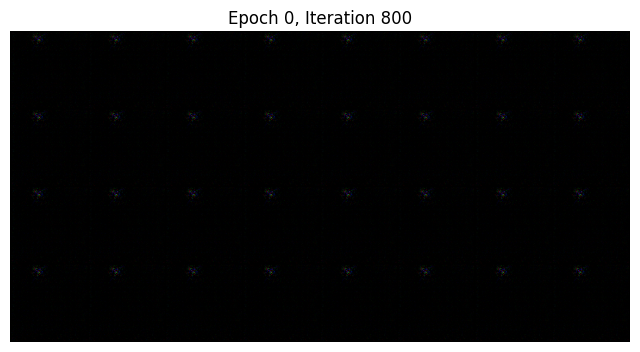

[0/5][850/6332]	Loss_D: 0.0002	Loss_G: 8.8577	D(x): 13.0829	D(G(z)): -8.6890 / -8.8576
[0/5][900/6332]	Loss_D: 0.0001	Loss_G: 9.6848	D(x): 12.4162	D(G(z)): -9.5929 / -9.6847
[0/5][950/6332]	Loss_D: 0.0001	Loss_G: 9.6069	D(x): 12.3008	D(G(z)): -9.4492 / -9.6069
[0/5][1000/6332]	Loss_D: 0.0003	Loss_G: 9.2438	D(x): 11.2383	D(G(z)): -9.0289 / -9.2437


<Figure size 640x480 with 0 Axes>

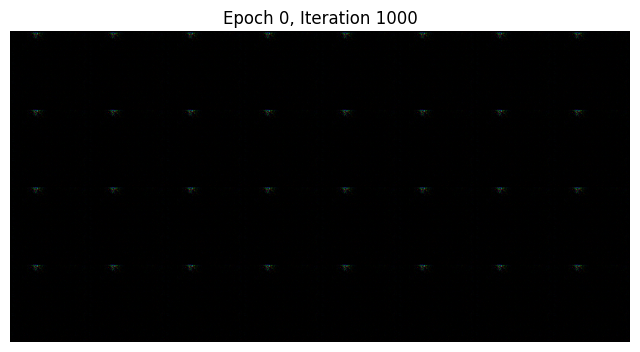

[0/5][1050/6332]	Loss_D: 0.0001	Loss_G: 10.0179	D(x): 14.0116	D(G(z)): -9.8514 / -10.0179
[0/5][1100/6332]	Loss_D: 0.0001	Loss_G: 10.0128	D(x): 11.7861	D(G(z)): -9.9122 / -10.0128
[0/5][1150/6332]	Loss_D: 0.0000	Loss_G: 10.1747	D(x): 13.2266	D(G(z)): -10.1087 / -10.1747
[0/5][1200/6332]	Loss_D: 0.0001	Loss_G: 10.0488	D(x): 12.4815	D(G(z)): -9.9843 / -10.0487


<Figure size 640x480 with 0 Axes>

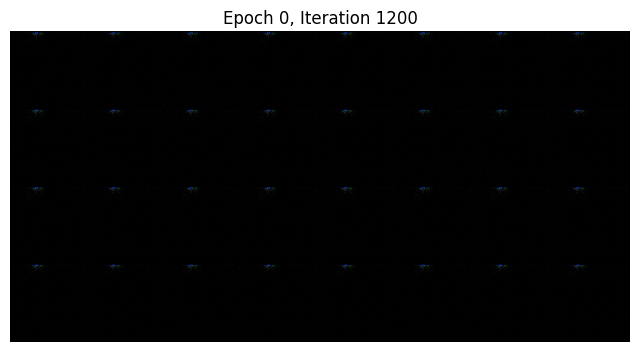

[0/5][1250/6332]	Loss_D: 0.0008	Loss_G: 10.1988	D(x): 10.3144	D(G(z)): -10.1855 / -10.1988
[0/5][1300/6332]	Loss_D: 0.0001	Loss_G: 9.9311	D(x): 12.5188	D(G(z)): -9.8687 / -9.9310
[0/5][1350/6332]	Loss_D: 0.0001	Loss_G: 9.8997	D(x): 15.0733	D(G(z)): -9.8402 / -9.8996
[0/5][1400/6332]	Loss_D: 0.0001	Loss_G: 9.7765	D(x): 13.7403	D(G(z)): -9.7208 / -9.7764


<Figure size 640x480 with 0 Axes>

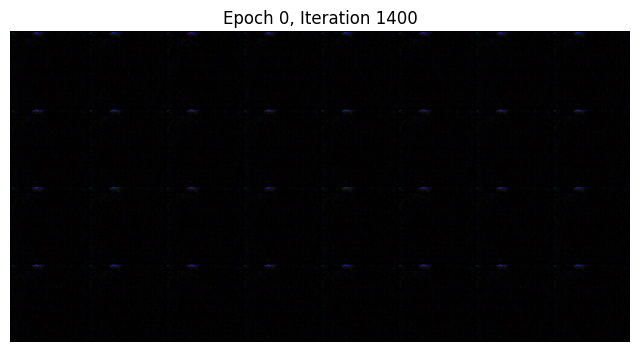

[0/5][1450/6332]	Loss_D: 0.0001	Loss_G: 9.1637	D(x): 14.2238	D(G(z)): -9.0536 / -9.1636
[0/5][1500/6332]	Loss_D: 0.0001	Loss_G: 9.7277	D(x): 14.3326	D(G(z)): -9.6647 / -9.7276
[0/5][1550/6332]	Loss_D: 0.0001	Loss_G: 10.0077	D(x): 13.4807	D(G(z)): -9.9685 / -10.0076
[0/5][1600/6332]	Loss_D: 0.0000	Loss_G: 10.0926	D(x): 13.7340	D(G(z)): -10.0476 / -10.0926


<Figure size 640x480 with 0 Axes>

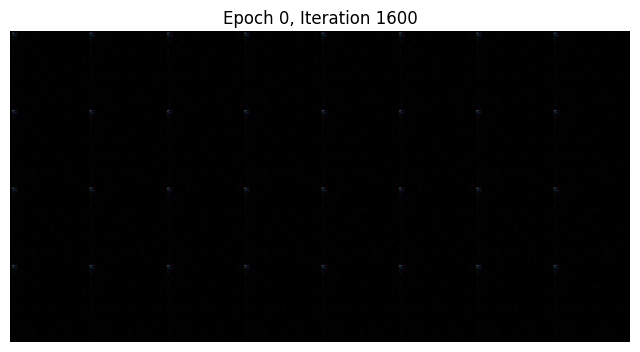

[0/5][1650/6332]	Loss_D: 0.0001	Loss_G: 10.0698	D(x): 13.4763	D(G(z)): -10.0229 / -10.0697
[0/5][1700/6332]	Loss_D: 0.0001	Loss_G: 10.1680	D(x): 11.3700	D(G(z)): -10.1189 / -10.1680
[0/5][1750/6332]	Loss_D: 0.0001	Loss_G: 10.1359	D(x): 13.6122	D(G(z)): -10.0735 / -10.1358
[0/5][1800/6332]	Loss_D: 0.0000	Loss_G: 10.0364	D(x): 15.0534	D(G(z)): -9.9479 / -10.0363


<Figure size 640x480 with 0 Axes>

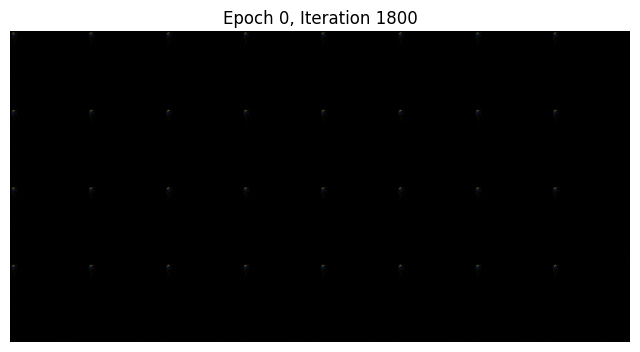

[0/5][1850/6332]	Loss_D: 0.0001	Loss_G: 9.8755	D(x): 13.9448	D(G(z)): -9.7344 / -9.8755
[0/5][1900/6332]	Loss_D: 0.0001	Loss_G: 10.1659	D(x): 12.8423	D(G(z)): -9.9708 / -10.1658
[0/5][1950/6332]	Loss_D: 0.0001	Loss_G: 10.2843	D(x): 11.7636	D(G(z)): -10.1403 / -10.2842
[0/5][2000/6332]	Loss_D: 0.0001	Loss_G: 10.9573	D(x): 12.4067	D(G(z)): -10.9026 / -10.9573


<Figure size 640x480 with 0 Axes>

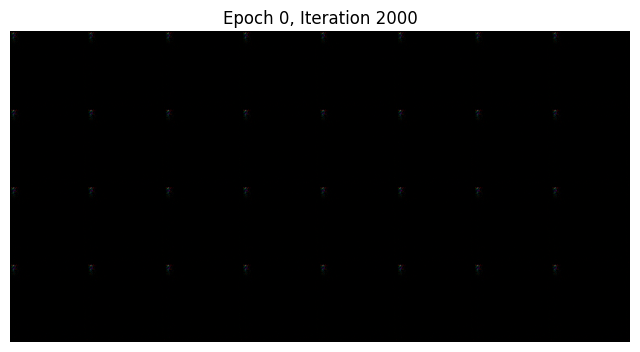

[1/5][0/6332]	Loss_D: 0.0000	Loss_G: 10.8847	D(x): 14.0346	D(G(z)): -10.8243 / -10.8847
[1/5][50/6332]	Loss_D: 0.0000	Loss_G: 10.9368	D(x): 14.4662	D(G(z)): -10.8811 / -10.9368
[1/5][100/6332]	Loss_D: 0.0000	Loss_G: 11.5700	D(x): 14.5638	D(G(z)): -11.5408 / -11.5699
[1/5][150/6332]	Loss_D: 0.0000	Loss_G: 11.3156	D(x): 14.3373	D(G(z)): -11.2883 / -11.3156


<Figure size 640x480 with 0 Axes>

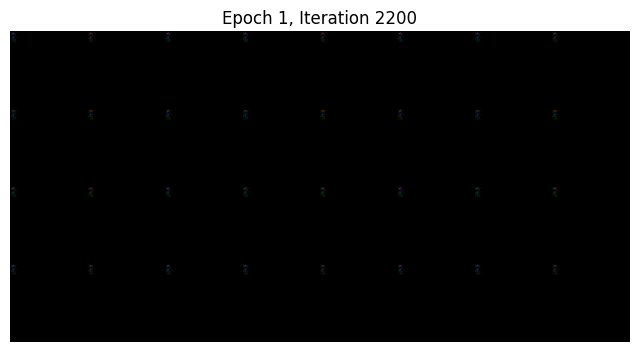

[1/5][200/6332]	Loss_D: 0.0000	Loss_G: 11.3677	D(x): 14.7447	D(G(z)): -11.3370 / -11.3676
[1/5][250/6332]	Loss_D: 0.0000	Loss_G: 11.9445	D(x): 15.2954	D(G(z)): -11.9237 / -11.9445
[1/5][300/6332]	Loss_D: 0.0000	Loss_G: 11.7767	D(x): 14.5486	D(G(z)): -11.7487 / -11.7767
[1/5][350/6332]	Loss_D: 0.0000	Loss_G: 11.2103	D(x): 14.5884	D(G(z)): -11.1700 / -11.2103


<Figure size 640x480 with 0 Axes>

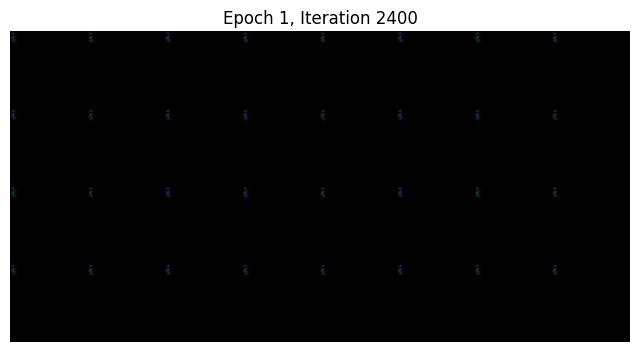

[1/5][400/6332]	Loss_D: 0.0000	Loss_G: 11.8342	D(x): 14.8263	D(G(z)): -11.8041 / -11.8342
[1/5][450/6332]	Loss_D: 0.0000	Loss_G: 11.4929	D(x): 14.7581	D(G(z)): -11.4673 / -11.4929
[1/5][500/6332]	Loss_D: 0.0000	Loss_G: 11.6175	D(x): 15.1207	D(G(z)): -11.5910 / -11.6175
[1/5][550/6332]	Loss_D: 0.0000	Loss_G: 11.6044	D(x): 14.5632	D(G(z)): -11.5703 / -11.6044


<Figure size 640x480 with 0 Axes>

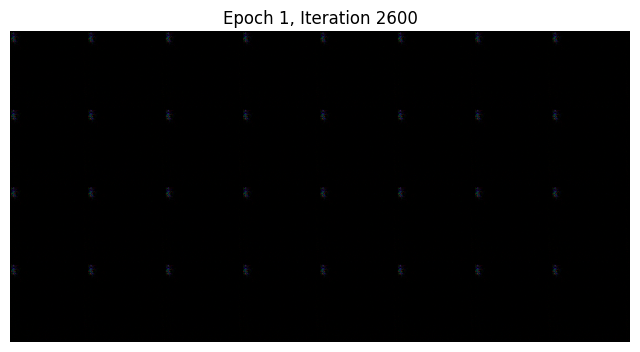

[1/5][600/6332]	Loss_D: 0.0000	Loss_G: 11.7541	D(x): 15.7865	D(G(z)): -11.7199 / -11.7540
[1/5][650/6332]	Loss_D: 0.0000	Loss_G: 11.8179	D(x): 14.2350	D(G(z)): -11.7909 / -11.8179
[1/5][700/6332]	Loss_D: 0.0000	Loss_G: 12.0115	D(x): 14.1796	D(G(z)): -11.9853 / -12.0115
[1/5][750/6332]	Loss_D: 0.0000	Loss_G: 11.7829	D(x): 16.0789	D(G(z)): -11.7534 / -11.7829


<Figure size 640x480 with 0 Axes>

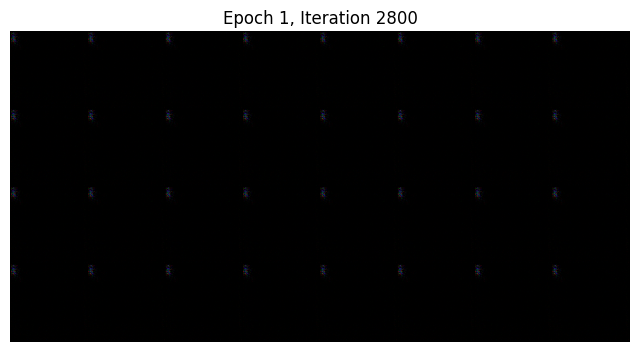

[1/5][800/6332]	Loss_D: 0.0000	Loss_G: 11.8918	D(x): 16.3475	D(G(z)): -11.8673 / -11.8918
[1/5][850/6332]	Loss_D: 0.0000	Loss_G: 11.7758	D(x): 15.1359	D(G(z)): -11.7586 / -11.7758
[1/5][900/6332]	Loss_D: 0.0000	Loss_G: 12.0007	D(x): 15.3647	D(G(z)): -11.9694 / -12.0007
[1/5][950/6332]	Loss_D: 0.0000	Loss_G: 12.2870	D(x): 14.8116	D(G(z)): -12.2533 / -12.2870


<Figure size 640x480 with 0 Axes>

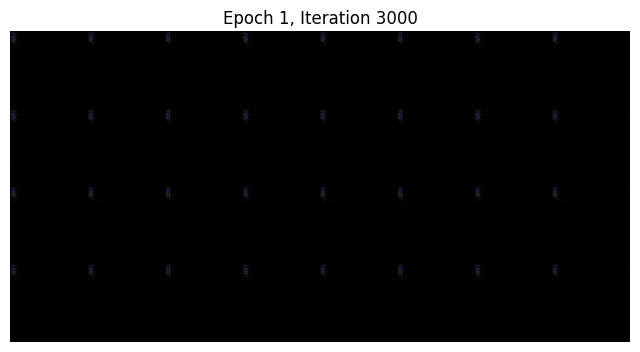

[1/5][1000/6332]	Loss_D: 0.0000	Loss_G: 11.9499	D(x): 13.9102	D(G(z)): -11.8877 / -11.9499
[1/5][1050/6332]	Loss_D: 0.0000	Loss_G: 11.3807	D(x): 16.1246	D(G(z)): -11.3046 / -11.3807
[1/5][1100/6332]	Loss_D: 0.0000	Loss_G: 11.6859	D(x): 15.7342	D(G(z)): -11.5885 / -11.6859
[1/5][1150/6332]	Loss_D: 0.0000	Loss_G: 11.6013	D(x): 16.4603	D(G(z)): -11.5133 / -11.6013


<Figure size 640x480 with 0 Axes>

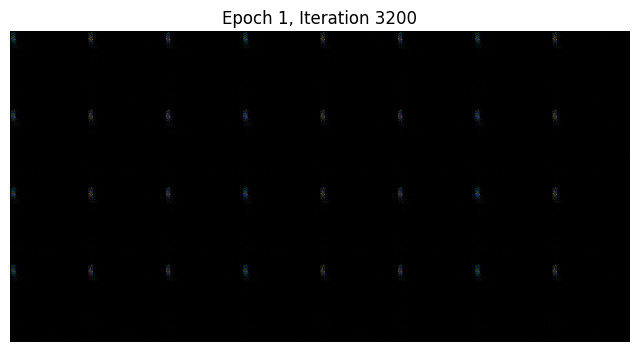

[1/5][1200/6332]	Loss_D: 0.0000	Loss_G: 12.0083	D(x): 14.3052	D(G(z)): -11.9407 / -12.0083
[1/5][1250/6332]	Loss_D: 0.0000	Loss_G: 11.7447	D(x): 15.2408	D(G(z)): -11.6777 / -11.7447
[1/5][1300/6332]	Loss_D: 0.0000	Loss_G: 11.8908	D(x): 15.2023	D(G(z)): -11.8309 / -11.8908
[1/5][1350/6332]	Loss_D: 0.0000	Loss_G: 12.4643	D(x): 15.3846	D(G(z)): -12.4214 / -12.4643


<Figure size 640x480 with 0 Axes>

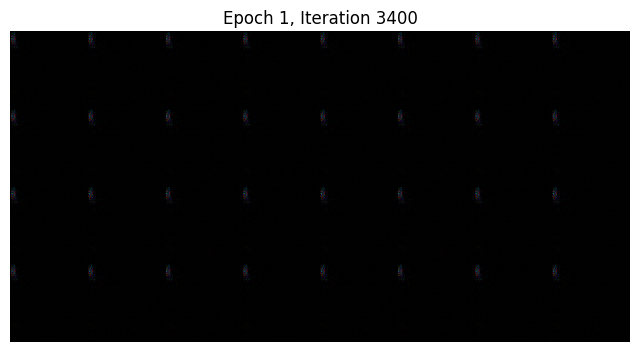

[1/5][1400/6332]	Loss_D: 0.0000	Loss_G: 11.9789	D(x): 16.3143	D(G(z)): -11.9243 / -11.9789
[1/5][1450/6332]	Loss_D: 0.0000	Loss_G: 11.8824	D(x): 13.5186	D(G(z)): -11.8253 / -11.8824
[1/5][1500/6332]	Loss_D: 0.0000	Loss_G: 12.3292	D(x): 16.2762	D(G(z)): -12.2884 / -12.3292
[1/5][1550/6332]	Loss_D: 0.0000	Loss_G: 11.9087	D(x): 15.6914	D(G(z)): -11.8631 / -11.9087


<Figure size 640x480 with 0 Axes>

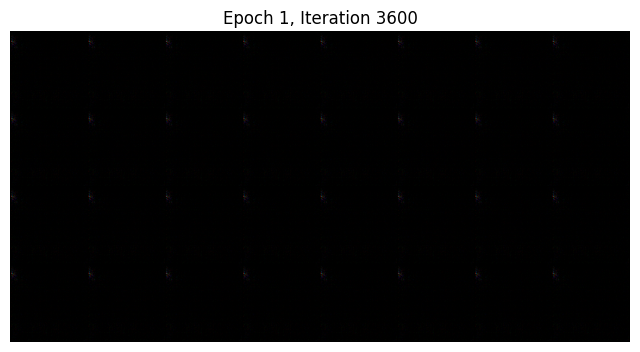

[1/5][1600/6332]	Loss_D: 0.0000	Loss_G: 11.2679	D(x): 15.2750	D(G(z)): -11.2046 / -11.2679
[1/5][1650/6332]	Loss_D: 0.0000	Loss_G: 11.8032	D(x): 15.8545	D(G(z)): -11.7596 / -11.8032
[1/5][1700/6332]	Loss_D: 0.0000	Loss_G: 11.4827	D(x): 16.9260	D(G(z)): -11.4408 / -11.4827
[1/5][1750/6332]	Loss_D: 0.0000	Loss_G: 10.6998	D(x): 14.8655	D(G(z)): -10.5851 / -10.6998


<Figure size 640x480 with 0 Axes>

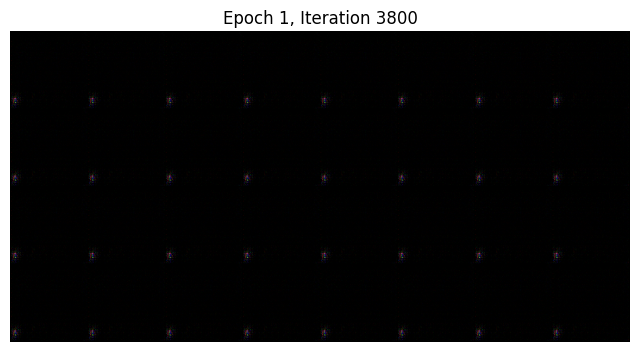

[1/5][1800/6332]	Loss_D: 0.0000	Loss_G: 10.4322	D(x): 14.7830	D(G(z)): -10.2089 / -10.4322
[1/5][1850/6332]	Loss_D: 0.0000	Loss_G: 10.5595	D(x): 13.6568	D(G(z)): -10.4681 / -10.5595


RuntimeError: Caught RuntimeError in DataLoader worker process 1.
Original Traceback (most recent call last):
  File "d:\itmo\deep_gen_itmo\hw_2\.venv\Lib\site-packages\torch\utils\data\_utils\worker.py", line 349, in _worker_loop
    data = fetcher.fetch(index)  # type: ignore[possibly-undefined]
           ^^^^^^^^^^^^^^^^^^^^
  File "d:\itmo\deep_gen_itmo\hw_2\.venv\Lib\site-packages\torch\utils\data\_utils\fetch.py", line 55, in fetch
    return self.collate_fn(data)
           ^^^^^^^^^^^^^^^^^^^^^
  File "d:\itmo\deep_gen_itmo\hw_2\.venv\Lib\site-packages\torch\utils\data\_utils\collate.py", line 398, in default_collate
    return collate(batch, collate_fn_map=default_collate_fn_map)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "d:\itmo\deep_gen_itmo\hw_2\.venv\Lib\site-packages\torch\utils\data\_utils\collate.py", line 212, in collate
    collate(samples, collate_fn_map=collate_fn_map)
  File "d:\itmo\deep_gen_itmo\hw_2\.venv\Lib\site-packages\torch\utils\data\_utils\collate.py", line 155, in collate
    return collate_fn_map[elem_type](batch, collate_fn_map=collate_fn_map)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "d:\itmo\deep_gen_itmo\hw_2\.venv\Lib\site-packages\torch\utils\data\_utils\collate.py", line 270, in collate_tensor_fn
    storage = elem._typed_storage()._new_shared(numel, device=elem.device)
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "d:\itmo\deep_gen_itmo\hw_2\.venv\Lib\site-packages\torch\storage.py", line 1199, in _new_shared
    untyped_storage = torch.UntypedStorage._new_shared(
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "d:\itmo\deep_gen_itmo\hw_2\.venv\Lib\site-packages\torch\storage.py", line 410, in _new_shared
    return cls._new_using_filename_cpu(size)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
RuntimeError: Couldn't open shared file mapping: <torch_13716_2273375543_1876>, error code: <1455>


<Figure size 640x480 with 0 Axes>

In [16]:
%load_ext tensorboard


from torch.utils.tensorboard import SummaryWriter
from tensorboard import notebook

writer = SummaryWriter()
notebook.start("--logdir runs") 

img_list = []    # Список для сохранения сгенерированных изображений
G_losses = []    # Список для сохранения потерь генератора
D_losses = []    # Список для сохранения потерь дискриминатора
iters = 0        # Счетчик итераций


for epoch in range(0, n_epochs):
    for i, data in enumerate(dataloader, 0):
        
        # Обучение дискриминатора
        discriminator.zero_grad()                                 # Обнуляем градиенты D
        real = data[0].to(device)                             # Загружаем батч реальных изображений
        b_size = real.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        output = discriminator(real).view(-1)                  # Прямой проход реальных изображений через D
        errD_real = criterion(output, label)                      # Потери на реальных изображениях
        errD_real.backward()                                      # Обратное распространение
        D_x = output.mean().item()                                # Средний вывод D для реальных изображений

        # Генерация фейковых изображений
        noise = torch.randn(b_size, n_channels_start, shape_start, shape_start, device=device)
        fake = generator(noise)                                   # Генерация фейкового батча
        label.fill_(fake_label)
        output = discriminator(fake.detach()).view(-1)            # Классификация фейкового батча
        errD_fake = criterion(output, label)                      # Потери на фейковых изображениях
        errD_fake.backward()                                      # Обратное распространение
        D_G_z1 = output.mean().item()                             # Средний вывод D для фейков
        errD = errD_real + errD_fake                              # Суммарные потери D
        optimizer_disc.step()                                     # Обновляем веса D

        # Обучение генератора
        generator.zero_grad()                                     # Обнуляем градиенты G
        label.fill_(real_label)                                   # Меняем метки для обучения G
        output = discriminator(fake).view(-1)                     # Повторный проход через обновленный D
        errG = criterion(output, label)                           # Потери генератора
        errG.backward()                                           # Обратное распространение
        D_G_z2 = output.mean().item()                             # Средний вывод D после обновления G
        optimizer_gen.step()                                      # Обновляем веса G

        # Логирование в TensorBoard
        writer.add_scalars('Loss', {
            'Discriminator': errD.item(),
            'Generator': errG.item(),
        }, iters)
        writer.add_scalar('D(x)', D_x, iters)
        writer.add_scalar('D(G(z))', D_G_z1, iters)
        writer.flush()  # Для live-обновления TensorBoard

        # Выводим статистику обучения
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, n_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Визуализация сгенерированных изображений каждые 200 итераций

        if (iters % 200 == 0) or ((epoch == n_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = generator(fixed_noise).detach().cpu()
                img_grid = make_grid(fake, padding=2, normalize=True)
                
                # Log to TensorBoard
                writer.add_image('Generated_images', img_grid, iters)
                writer.flush()
                
                plt.figure(figsize=(8, 8))
                plt.axis("off")
                plt.title(f"Epoch {epoch}, Iteration {iters}")
                plt.imshow(img_grid.permute(1, 2, 0)) 
                plt.show()
                
                # Optional: Save the figure for later reference
                img_list.append(plt.gcf())

        iters += 1
        if i == 2000:
            break

writer.close()

<Figure size 640x480 with 0 Axes>

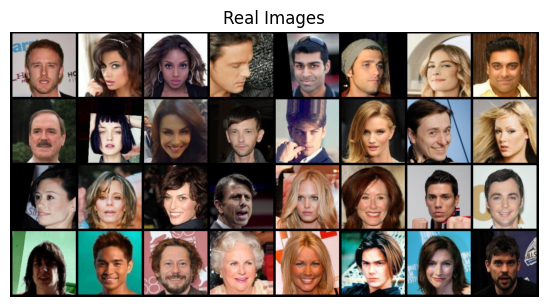

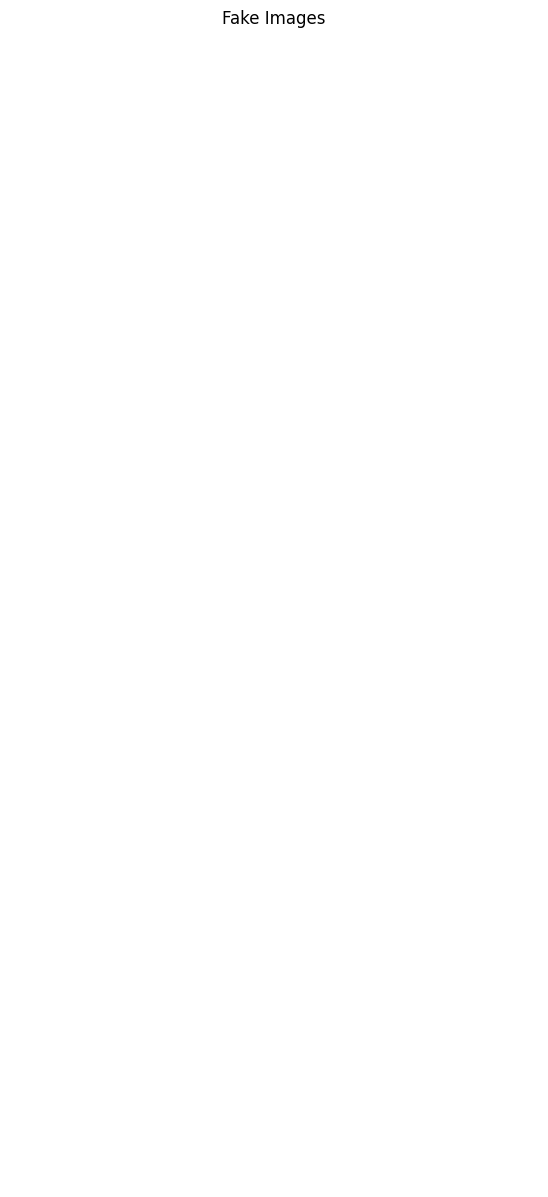

In [ ]:
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).to('cpu'),(1,2,0)))

# Plot the fake images from the last epoch
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Fake Images")
img_list[-1]